In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torch
import time
from swyft.deps import UNet
from IPython.utils import io
import logging

import swyft
import pylab as plt
import scipy.stats.distributions as dist
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generative model

In [33]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1, bounds_theta = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.000001)], bounds = bounds_theta)
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e6*3*(k/0.5+1)**-theta[0]
        
    def sample_delta(self, pk_fn, use_bounds = True):
        if self.bounds is not None and use_bounds:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
        return rho
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        delta_unbound = graph.node("delta_unbound", lambda pk_fn: self.sample_delta(pk_fn, use_bounds = False), pk_fn)
        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
        x = graph.node("x", lambda rho: self.psf(rho) + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        z = graph.node("test", lambda: lambda x: x)

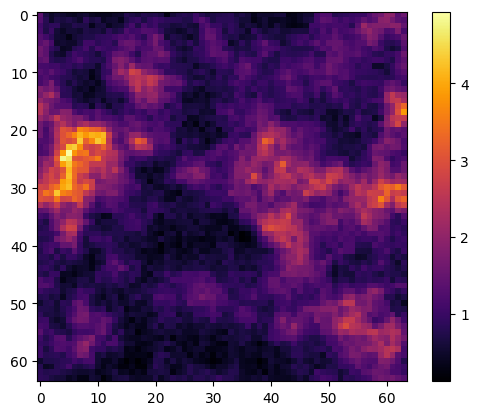

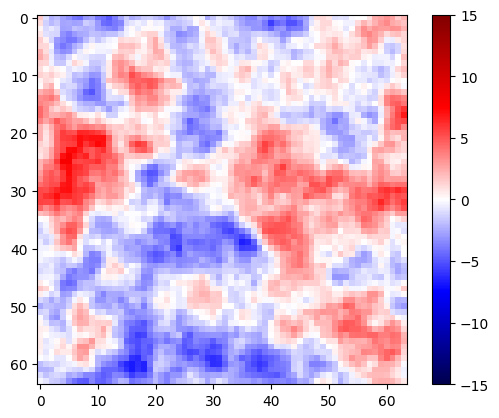

In [34]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample(conditions = dict(theta = np.array([4.])))
del sample0['pk_fn']
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()
plt.show()
plt.imshow(sample0['delta'], vmin = -15, vmax = 15, cmap = 'seismic')
plt.colorbar()
plt.show()

### Inference network

In [35]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = UNet(1, 1, hidden_channels = 4)
        self.cnn = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, 3), torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            #torch.nn.LazyConv2d(64, 3), torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.mlp = torch.nn.Sequential(
            torch.nn.LazyLinear(256), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(128), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(4)
        )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, 3), torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            #torch.nn.LazyConv2d(64, 3), torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.mlp3 = torch.nn.Sequential(
            torch.nn.LazyLinear(256), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(128), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(4)
        )

        self.lre2 = swyft.LogRatioEstimator_1dim(4, 1, 'theta:delta')
        self.lre3 = swyft.LogRatioEstimator_1dim(4, 1, 'theta')

        self.norm2b = torch.nn.LazyBatchNorm1d()
        self.norm2a = torch.nn.LazyBatchNorm2d()
        self.norm1 = torch.nn.LazyBatchNorm2d()
        self.norm3 = torch.nn.LazyBatchNorm2d()
    
    def embed(self, x):
        x = self.norm1(x.unsqueeze(1)).squeeze(1)
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def embed2a(self, delta):
        f = self.norm2a(delta)
        f = self.cnn(f.unsqueeze(1)).flatten(start_dim = 1)
        f = self.mlp(f)
        return f

    def embed2b(self, delta):
        f = swyft.utils.ps.get_pk(delta)
        f = self.norm2b(f)
        f = self.mlp(f)
        return f

    def embed3(self, x):
        x = self.norm3(x.unsqueeze(1)).squeeze(1)
        f = self.cnn3(x.unsqueeze(1)).flatten(start_dim = 1)
        f = self.mlp3(f)
        return f

    def forward(self, A, B):
        N = self.N
        try:
            rhoA = self.embed(A['x'])
            rhoB = self.embed(B['x'])
            deltaB = B['delta'].view(-1, N**2)
            result1 = self.lre(rhoA, rhoB, deltaB)
        except KeyError:
            result1 = None

        try:
            f2 = self.embed2b(A['delta_unbound'])
            result2 = self.lre2(f2, B['theta'])
        except KeyError:
            result2 = None

        try:
            f3 = self.embed3(A['x'])
            result3 = self.lre3(f3, B['theta'])
        except KeyError:
            result3 = None
        
        return result1, result2, result3

In [36]:
class Network_delta_x(swyft.SwyftModule):
    def __init__(self, N = 64):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = unet.UNet(1, 1, s = 4)
        self.norm1 = torch.nn.LazyBatchNorm2d()
    
    def embed(self, x):
        x = self.norm1(x.unsqueeze(1)).squeeze(1)
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        N = self.N
        try:
            rhoA = self.embed(A['x'])
            rhoB = self.embed(B['x'])
            deltaB = B['delta'].view(-1, N**2)
            result1 = self.lre(rhoA, rhoB, deltaB)
        except KeyError:
            result1 = None
        
        return result1

In [37]:
class Network_theta_x(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.cnn3 = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, 3), torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            #torch.nn.LazyConv2d(64, 3), torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.mlp3 = torch.nn.Sequential(
            torch.nn.LazyLinear(256), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(128), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(4)
        )
        self.lre3 = swyft.LogRatioEstimator_1dim(4, 1, 'theta', num_blocks = 4, hidden_features = 128)
        self.norm3 = torch.nn.LazyBatchNorm2d()
    
    def embed3(self, x):
        x = self.norm3(x.unsqueeze(1)).squeeze(1)
        f = self.cnn3(x.unsqueeze(1)).flatten(start_dim = 1)
        f = self.mlp3(f)
        return f

    def forward(self, A, B):
        f3 = self.embed3(A['x'])
        result = self.lre3(f3, B['theta'])
        
        return result

### Inference

In [38]:
def get_samples(n_sims = 1000, bounds = None, bounds_theta = None):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds, bounds_theta = bounds_theta)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    return sim, samples

In [39]:
def train_theta_x(samples, max_epochs = 5):
    dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
    net = Network_theta_x()
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = [0], max_epochs = max_epochs, precision = 32)
    logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)
    trainer.fit(net, dm)
    return trainer, net
    
def infer_theta_x(sample0, sim, trainer, net):
    prior_draws = sim.sample(10000, targets = ["theta"], exclude = ['pk_fn'])
    results = trainer.infer(net, sample0, prior_draws)
    swyft.plot_1d(results, 'theta[0]', smooth = 2, bins = 100)
    plt.show()
    bounds = swyft.collect_rect_bounds(results, 'theta', (1,))
    return results, bounds

In [40]:
def train_delta_x(samples, max_epochs = 5):
    dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
    net = Network_delta_x()
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = [0], max_epochs = max_epochs, precision = 32)
    logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)
    trainer.fit(net, dm)
    return trainer, net

def infer_delta_x(sample0, sim, trainer, net, n_draws = 10, gamma = 0.1):
    GAMMA = gamma
    x = sample0['x']
    d = sample0['delta']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    x0s = []
    for _ in tqdm(range(n_draws)):
        #pk = SimulatorBlob(Npix = NPIX).sample()['pk_fn']
        pk = sim.sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        x0s.append(x0)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = 300, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    x0s = torch.stack(x0s)
    
    bounds = [(x0s[i].view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)

    net.float()
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    #res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    print(x.min(), x.max(), bounds[0].min(), bounds[0].max())
    res = [d - bounds[i] for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()
    y = bounds.reshape(-1, NPIX**2)
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = ((y-x)/ys).flatten()
    plt.hist(diff, bins = 100)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = SimulatorBlob().sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()  

    return bounds

## The analysis

### Round 1

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1306.71it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  90%|█████████▊ | 43/48 [00:01<00:00, 24.82it/s, loss=-0.66, v_num=248]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████▊| 47/48 [00:01<00:00, 25.90it/s, loss=-0.66, v_num=248]
Epoch 0: 100%|█| 48/48 [00:01<00:00, 26.22it/s, loss=-0.66, v_num=248, val_loss=
Epoch 1:  90%|▉| 43/48 [00:01<00:00, 26.43it/s, loss=-0.731, v_num=248, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 44/48 [00:01<00:00, 26.51it/s, loss=-0.731, v_num=248, val_loss
Epoch 1:  94%|▉| 45/48 [00:01<00:00, 26.80it/s, loss=-0.731, v_num=248, val_loss
Epoch 1:  96%|▉| 46/48 [00:01<00:00, 27.13it/s, loss=-0.731, v_num=248, val_loss
Epoch 1:  98%|▉| 47/48 [00:01<00:00, 27.49it/s, loss=-0.731, v_num=248, val_loss
Epoch 1: 100%|█| 48/48 [00:01<00:00, 27.68it/s, loss=-0.731, v_num=248, val_loss
Epoch 2:  90%|▉| 43/48 [00:01<00:00, 27.48it/s, loss=-0.795, v_num=248, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataL

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 48/48 [00:01<00:00, 30.38it/s, loss=-1.14, v_num=248, val_loss


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 10541.84it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████| 10/10 [00:00<00:00, 144.15it/s]


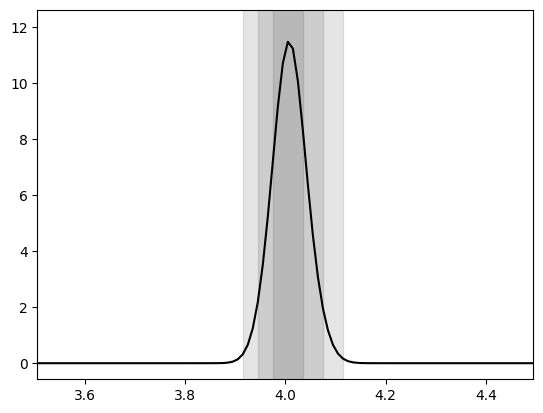

In [14]:
# Estimate theta from free x - round 1
sim, samples = get_samples(n_sims = 3000, bounds = None, bounds_theta = None)
trained_theta_x = train_theta_x(samples, max_epochs = 15)
results_theta_x, bounds_theta_x = infer_theta_x(sample0, sim, *trained_theta_x)

### Round 2

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1443.98it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  90%|████████▉ | 43/48 [00:01<00:00, 31.41it/s, loss=-0.492, v_num=249]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████▊| 47/48 [00:01<00:00, 32.26it/s, loss=-0.492, v_num=249]
Epoch 0: 100%|█| 48/48 [00:01<00:00, 32.59it/s, loss=-0.492, v_num=249, val_loss
Epoch 1:  90%|▉| 43/48 [00:01<00:00, 30.07it/s, loss=-0.678, v_num=249, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 44/48 [00:01<00:00, 30.14it/s, loss=-0.678, v_num=249, val_loss
Epoch 1:  94%|▉| 45/48 [00:01<00:00, 30.51it/s, loss=-0.678, v_num=249, val_loss
Epoch 1:  96%|▉| 46/48 [00:01<00:00, 30.87it/s, loss=-0.678, v_num=249, val_loss
Epoch 1:  98%|▉| 47/48 [00:01<00:00, 31.26it/s, loss=-0.678, v_num=249, val_loss
Epoch 1: 100%|█| 48/48 [00:01<00:00, 31.59it/s, loss=-0.678, v_num=249, val_loss
Epoch 2:  90%|▉| 43/48 [00:01<00:00, 30.59it/s, loss=-0.741, v_num=249, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataL

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.
Epoch 14: 100%|█| 48/48 [00:01<00:00, 29.25it/s, loss=-1.12, v_num=249, val_loss


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 10250.69it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████| 10/10 [00:00<00:00, 100.25it/s]


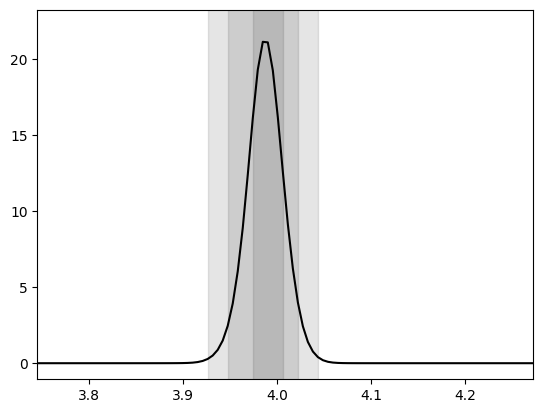

In [15]:
# Estimate theta from free x - round 2
sim, samples = get_samples(n_sims = 3000, bounds = None, bounds_theta = bounds_theta_x)
trained_theta_x = train_theta_x(samples, max_epochs = 15)
results_theta_x, bounds_theta_x = infer_theta_x(sample0, sim, *trained_theta_x)
print(bounds_theta_x)

### Round 3

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1267.43it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre   | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet  | UNet                                                     | 1.9 M 
2 | norm1 | LazyBatchNorm2d                                          | 0     
-----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  90%|██████████▊ | 43/48 [00:02<00:00, 15.69it/s, loss=-917, v_num=254]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████████▊| 47/48 [00:02<00:00, 16.24it/s, loss=-917, v_num=254]
Epoch 0: 100%|█| 48/48 [00:02<00:00, 16.41it/s, loss=-917, v_num=254, val_loss=-
Epoch 1:  90%|▉| 43/48 [00:02<00:00, 16.45it/s, loss=-4.96e+03, v_num=254, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 44/48 [00:02<00:00, 16.54it/s, loss=-4.96e+03, v_num=254, val_l
Epoch 1:  94%|▉| 45/48 [00:02<00:00, 16.75it/s, loss=-4.96e+03, v_num=254, val_l
Epoch 1:  96%|▉| 46/48 [00:02<00:00, 16.89it/s, loss=-4.96e+03, v_num=254, val_l
Epoch 1:  98%|▉| 47/48 [00:02<00:00, 17.09it/s, loss=-4.96e+03, v_num=254, val_l
Epoch 1: 100%|█| 48/48 [00:02<00:00, 17.22it/s, loss=-4.96e+03, v_num=254, val_l
Epoch 2:  90%|▉| 43/48 [00:02<00:00, 17.31it/s, loss=-6e+03, v_num=254, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataL

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 48/48 [00:02<00:00, 18.32it/s, loss=-7.25e+03, v_num=254, val_


100%|█████████████████████████████████████████| 300/300 [00:35<00:00,  8.33it/s]


0.12245023 4.9312997 -10.879688737647964 8.415157356824903


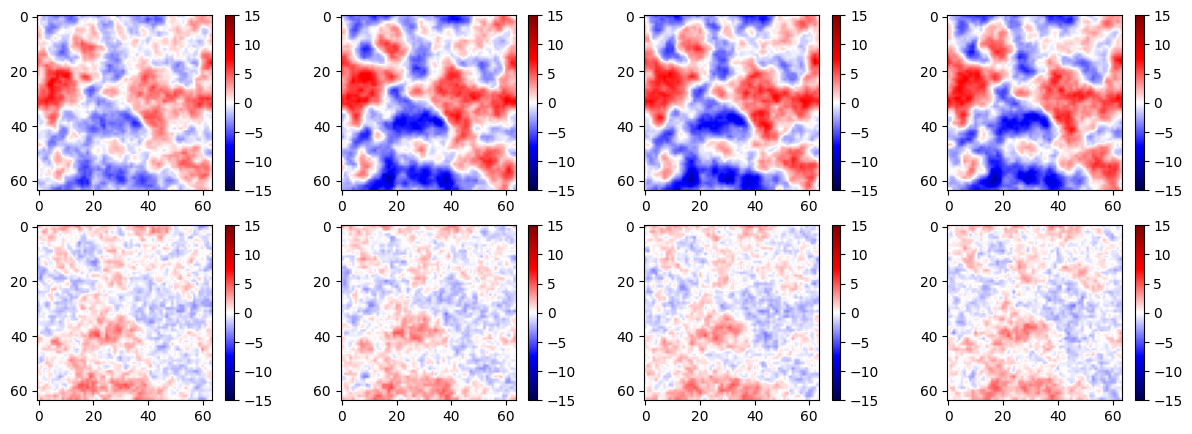

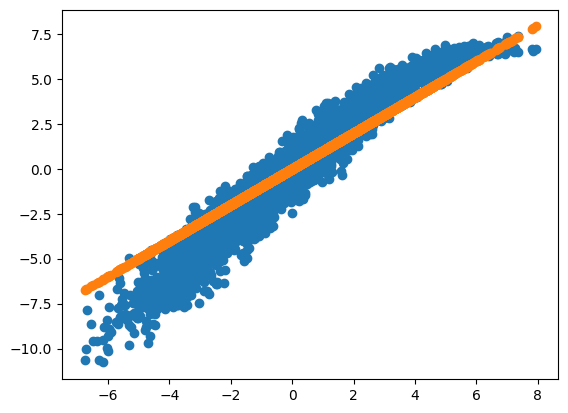

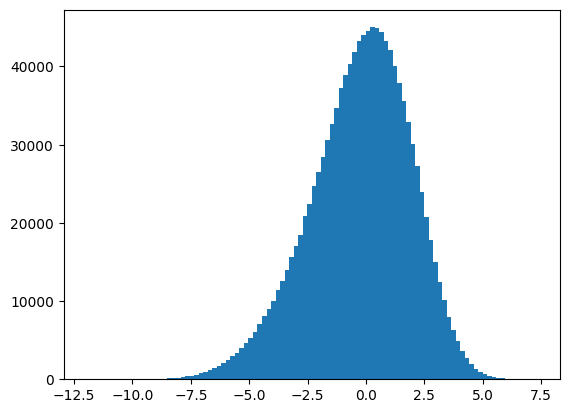

Residual percentiles: [-4.91907671 -2.40209753 -0.07130802  1.87848033  3.48861683]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1131.49it/s]


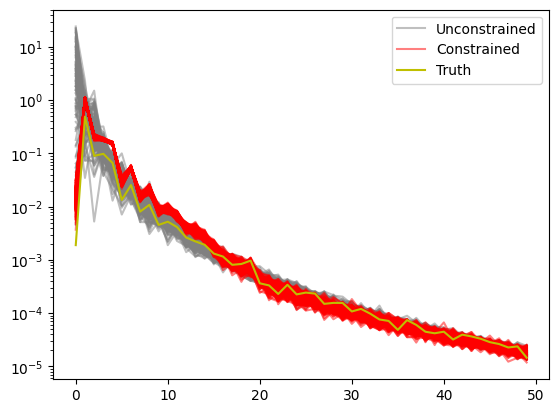

In [42]:
# Estimate delta from free x - round 3
bounds_theta_x = None
sim, samples = get_samples(n_sims = 3000, bounds = None, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 15)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 300)

### Round 4

100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1884.35it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre   | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet  | UNet                                                     | 1.9 M 
2 | norm1 | LazyBatchNorm2d                                          | 0     
-----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  90%|███████▏| 43/48 [00:02<00:00, 17.20it/s, loss=1.93e+04, v_num=255]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████▊| 47/48 [00:02<00:00, 17.72it/s, loss=1.93e+04, v_num=255]
Epoch 0: 100%|█| 48/48 [00:02<00:00, 17.89it/s, loss=1.93e+04, v_num=255, val_lo
Epoch 1:  90%|▉| 43/48 [00:02<00:00, 18.48it/s, loss=74.9, v_num=255, val_loss=1
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 44/48 [00:02<00:00, 18.50it/s, loss=74.9, v_num=255, val_loss=1
Epoch 1:  94%|▉| 45/48 [00:02<00:00, 18.58it/s, loss=74.9, v_num=255, val_loss=1
Epoch 1:  96%|▉| 46/48 [00:02<00:00, 18.72it/s, loss=74.9, v_num=255, val_loss=1
Epoch 1:  98%|▉| 47/48 [00:02<00:00, 18.75it/s, loss=74.9, v_num=255, val_loss=1
Epoch 1: 100%|█| 48/48 [00:02<00:00, 18.73it/s, loss=74.9, v_num=255, val_loss=-
Epoch 2:  90%|▉| 43/48 [00:02<00:00, 15.59it/s, loss=-1.55e+03, v_num=255, val_l
Validation: 0it [00:00, ?it/s]
Validation DataL

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 48/48 [00:02<00:00, 18.43it/s, loss=-2.57e+03, v_num=255, val_


100%|█████████████████████████████████████████| 300/300 [00:45<00:00,  6.60it/s]


0.12245023 4.9312997 -8.739801930942383 9.566828319634531


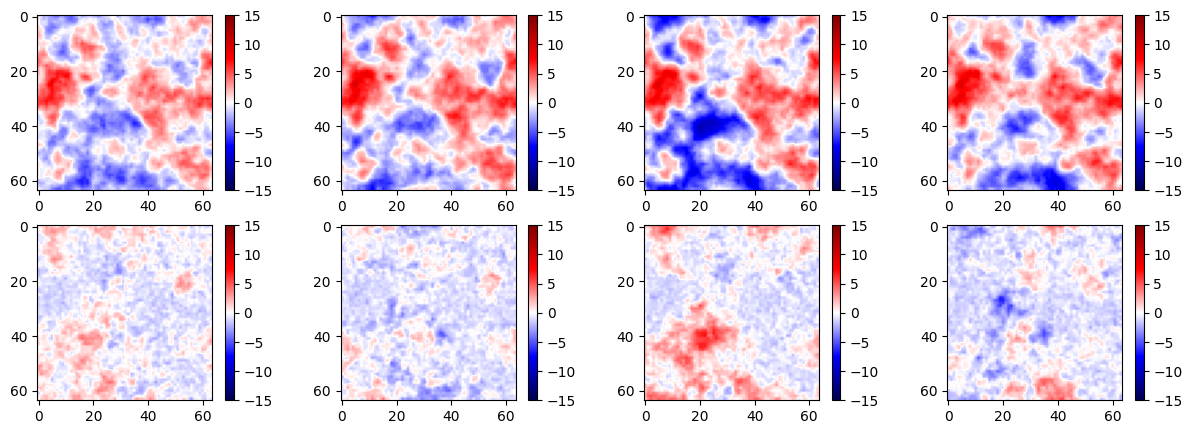

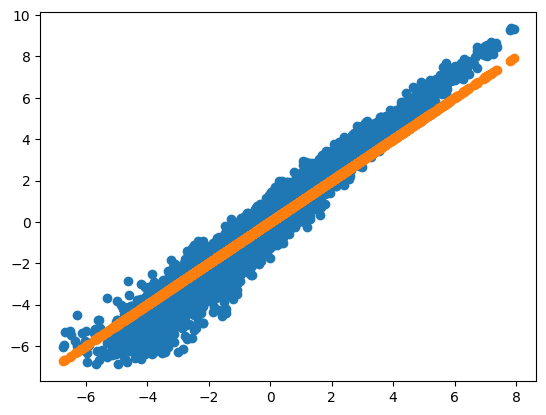

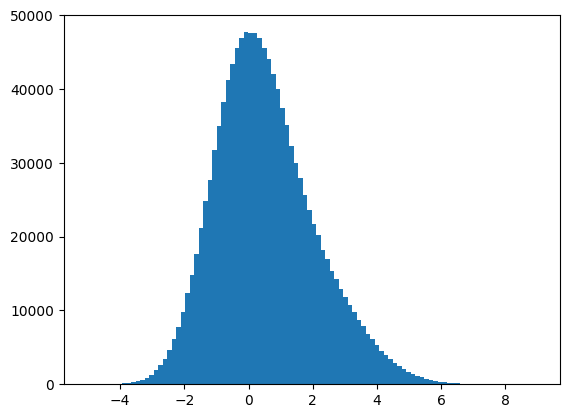

Residual percentiles: [-2.10735414 -0.96010372  0.37028571  2.08047495  3.99204264]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1161.18it/s]


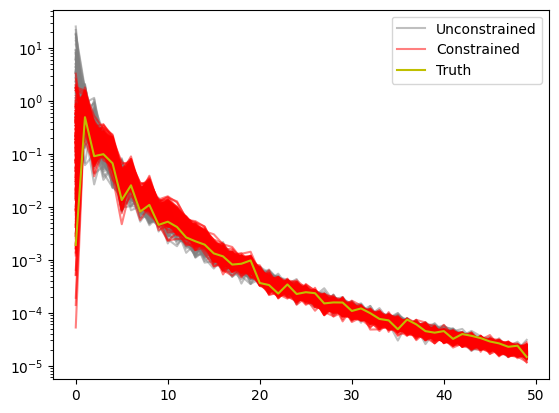

In [43]:
# Estimate delta from free x - round 4
sim, samples = get_samples(n_sims = 3000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 15)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 300)

100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1847.60it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre   | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet  | UNet                                                     | 1.9 M 
2 | norm1 | LazyBatchNorm2d                                          | 0     
-----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  90%|███████▏| 43/48 [00:02<00:00, 16.35it/s, loss=2.21e+04, v_num=256]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████▊| 47/48 [00:02<00:00, 16.82it/s, loss=2.21e+04, v_num=256]
Epoch 0: 100%|█| 48/48 [00:02<00:00, 16.98it/s, loss=2.21e+04, v_num=256, val_lo
Epoch 1:  90%|▉| 43/48 [00:02<00:00, 16.56it/s, loss=-211, v_num=256, val_loss=1
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 44/48 [00:02<00:00, 16.65it/s, loss=-211, v_num=256, val_loss=1
Epoch 1:  94%|▉| 45/48 [00:02<00:00, 16.85it/s, loss=-211, v_num=256, val_loss=1
Epoch 1:  96%|▉| 46/48 [00:02<00:00, 16.99it/s, loss=-211, v_num=256, val_loss=1
Epoch 1:  98%|▉| 47/48 [00:02<00:00, 17.10it/s, loss=-211, v_num=256, val_loss=1
Epoch 1: 100%|█| 48/48 [00:02<00:00, 17.17it/s, loss=-211, v_num=256, val_loss=-
Epoch 2:  90%|▉| 43/48 [00:02<00:00, 15.86it/s, loss=-2.45e+03, v_num=256, val_l
Validation: 0it [00:00, ?it/s]
Validation DataL

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 48/48 [00:02<00:00, 16.41it/s, loss=-3.9e+03, v_num=256, val_l


100%|█████████████████████████████████████████| 300/300 [00:39<00:00,  7.61it/s]


0.12245023 4.9312997 -10.830186547612762 8.904402906643497


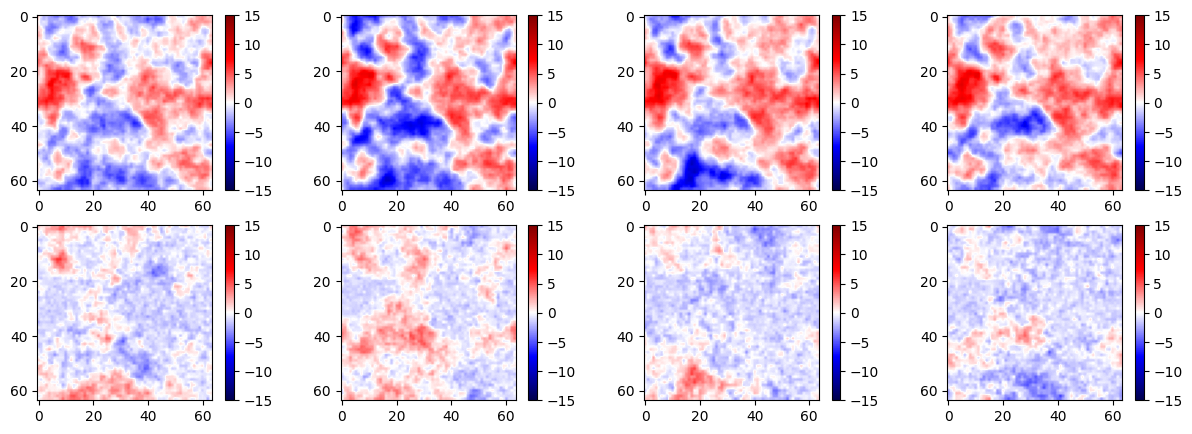

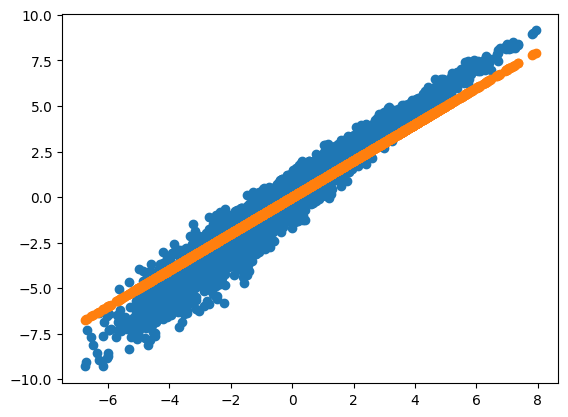

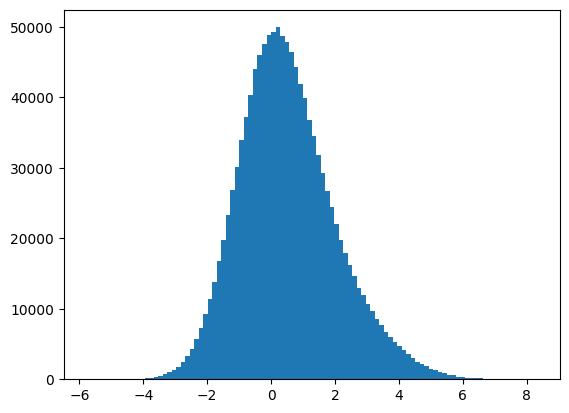

Residual percentiles: [-2.09234367 -0.91896554  0.38959227  1.99425805  3.92379748]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1459.09it/s]


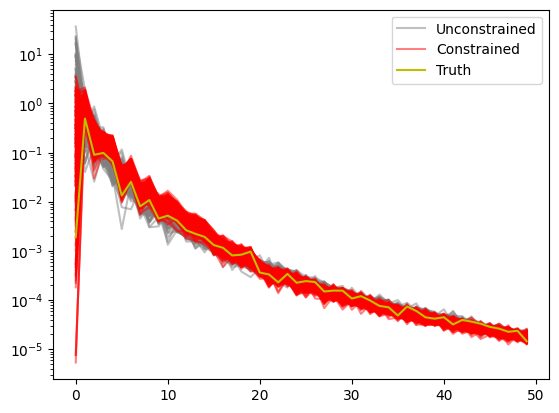

In [45]:
# Estimate delta from free x - round 3
sim, samples = get_samples(n_sims = 3000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 15)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 300)

100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1850.79it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre   | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet  | UNet                                                     | 1.9 M 
2 | norm1 | LazyBatchNorm2d                                          | 0     
-----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  90%|███████▏| 43/48 [00:02<00:00, 16.98it/s, loss=3.58e+04, v_num=257]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████▊| 47/48 [00:02<00:00, 17.35it/s, loss=3.58e+04, v_num=257]
Epoch 0: 100%|█| 48/48 [00:02<00:00, 17.36it/s, loss=3.58e+04, v_num=257, val_lo
Epoch 1:  90%|▉| 43/48 [00:02<00:00, 16.52it/s, loss=-132, v_num=257, val_loss=1
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 44/48 [00:02<00:00, 16.54it/s, loss=-132, v_num=257, val_loss=1
Epoch 1:  94%|▉| 45/48 [00:02<00:00, 16.72it/s, loss=-132, v_num=257, val_loss=1
Epoch 1:  96%|▉| 46/48 [00:02<00:00, 16.81it/s, loss=-132, v_num=257, val_loss=1
Epoch 1:  98%|▉| 47/48 [00:02<00:00, 16.97it/s, loss=-132, v_num=257, val_loss=1
Epoch 1: 100%|█| 48/48 [00:02<00:00, 17.07it/s, loss=-132, v_num=257, val_loss=-
Epoch 2:  90%|▉| 43/48 [00:02<00:00, 15.97it/s, loss=-3.03e+03, v_num=257, val_l
Validation: 0it [00:00, ?it/s]
Validation DataL

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 48/48 [00:02<00:00, 16.40it/s, loss=-4.45e+03, v_num=257, val_


100%|███████████████████████████████████████| 1000/1000 [02:13<00:00,  7.51it/s]


0.12245023 4.9312997 -9.172172570222191 9.231088395206198


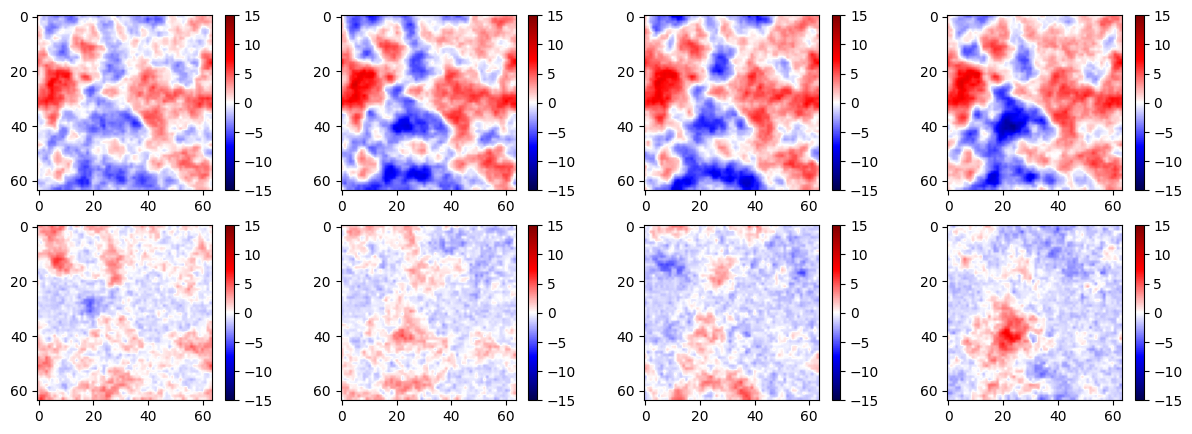

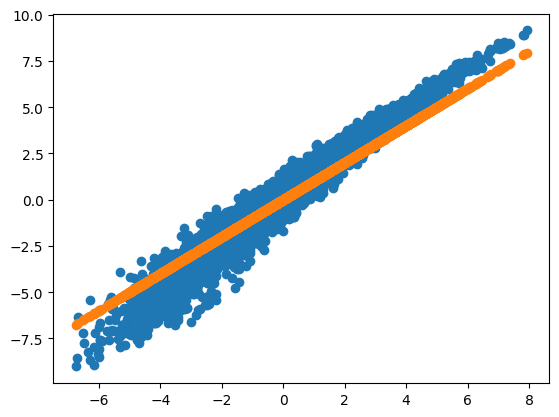

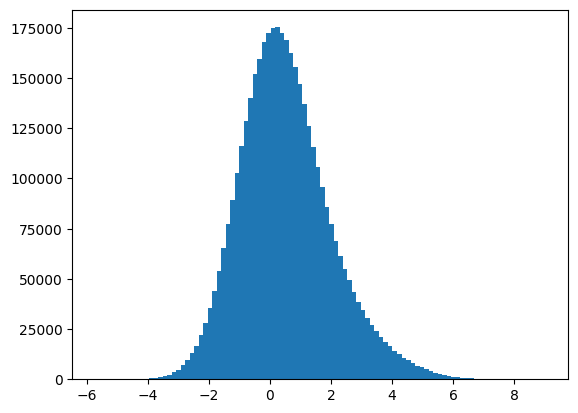

Residual percentiles: [-2.08598847 -0.91045705  0.39072556  1.95157202  3.92295294]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1499.42it/s]


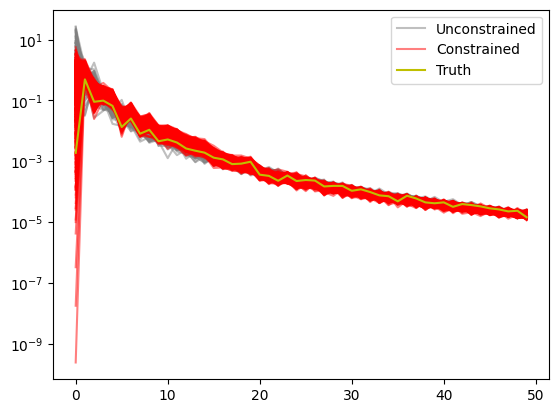

In [46]:
# Estimate delta from free x - round 3
sim, samples = get_samples(n_sims = 3000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 15)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 1000)

100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1795.86it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre   | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet  | UNet                                                     | 1.9 M 
2 | norm1 | LazyBatchNorm2d                                          | 0     
-----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  90%|███████▏| 43/48 [00:02<00:00, 17.97it/s, loss=2.99e+04, v_num=258]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████▊| 47/48 [00:02<00:00, 18.49it/s, loss=2.99e+04, v_num=258]
Epoch 0: 100%|█| 48/48 [00:02<00:00, 18.68it/s, loss=2.99e+04, v_num=258, val_lo
Epoch 1:  90%|▉| 43/48 [00:02<00:00, 16.66it/s, loss=-309, v_num=258, val_loss=1
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 44/48 [00:02<00:00, 16.69it/s, loss=-309, v_num=258, val_loss=1
Epoch 1:  94%|▉| 45/48 [00:02<00:00, 16.77it/s, loss=-309, v_num=258, val_loss=1
Epoch 1:  96%|▉| 46/48 [00:02<00:00, 16.96it/s, loss=-309, v_num=258, val_loss=1
Epoch 1:  98%|▉| 47/48 [00:02<00:00, 17.15it/s, loss=-309, v_num=258, val_loss=1
Epoch 1: 100%|█| 48/48 [00:02<00:00, 17.31it/s, loss=-309, v_num=258, val_loss=-
Epoch 2:  90%|▉| 43/48 [00:02<00:00, 16.88it/s, loss=-2.79e+03, v_num=258, val_l
Validation: 0it [00:00, ?it/s]
Validation DataL

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 48/48 [00:02<00:00, 17.66it/s, loss=-4.42e+03, v_num=258, val_


100%|███████████████████████████████████████| 1000/1000 [02:12<00:00,  7.53it/s]


0.12245023 4.9312997 -10.146798221531974 9.02924054845637


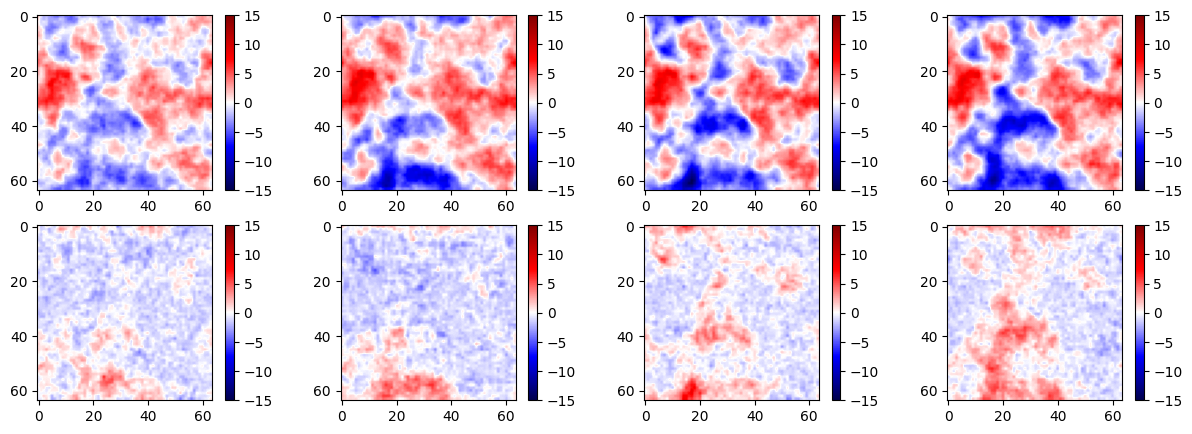

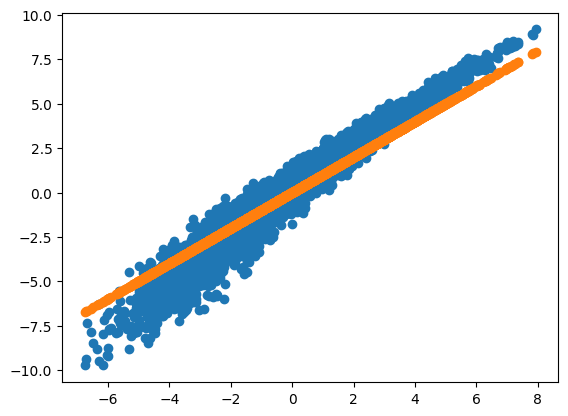

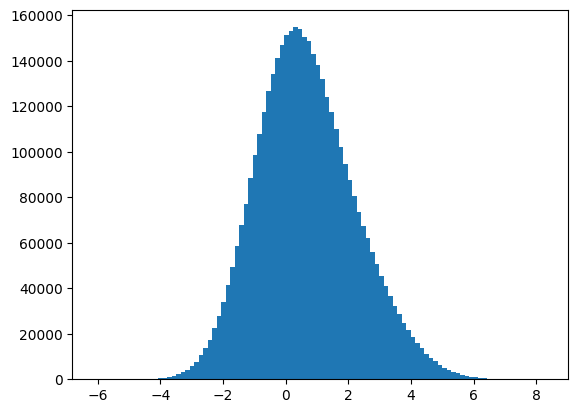

Residual percentiles: [-2.14319193 -0.87595812  0.55919566  2.244056    4.01244607]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1284.55it/s]


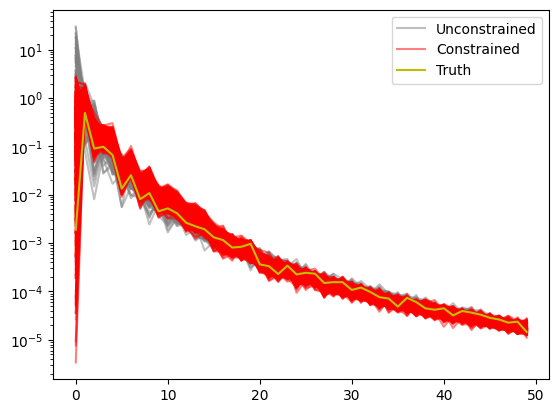

In [47]:
# Estimate delta from free x - round 3
sim, samples = get_samples(n_sims = 3000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 15)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 1000)

In [ ]:
# Estimate theta from constrained delta

In [ ]:
# Estimate theta from constrained x

In [14]:
def round(bounds = None, max_epochs = 5, n_sims = 1000, gamma = 0.1, n_draws = 200, slope = 4.):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    #net.cpu(); net.float()
    dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
    net = Network(N = NPIX)
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = [0], max_epochs = max_epochs, precision = 32)
    logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)
    trainer.fit(net, dm)
    
    GAMMA = gamma # 0.1 # 0.0001
    
    x = sample0['x']
    d = sample0['delta']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    x0s = []
    for _ in tqdm(range(n_draws)):
        pk = SimulatorBlob(Npix = NPIX).sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        x0s.append(x0)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = 300, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    x0s = torch.stack(x0s)
    
    bounds = [(x0s[i].view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)

    net.float()
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    #res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    print(x.min(), x.max(), bounds[0].min(), bounds[0].max())
    res = [d - bounds[i] for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()
    y = bounds.reshape(-1, NPIX**2)
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = ((y-x)/ys).flatten()
    plt.hist(diff, bins = 100)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = SimulatorBlob().sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()

    prior_draws = sim.sample(1000, targets = ["theta"], exclude = ['pk_fn'])
    results = trainer.infer(net, sample0, prior_draws)

    swyft.plot_1d(results, 'theta[0]', smooth = 1)
    plt.show()
    swyft.plot_1d(results, 'theta:delta[0]', smooth = 1)
    plt.title("Constraint from ground truth delta")
    plt.show()

    prior_draws = sim.sample(10000, targets = ["theta"], exclude = ['pk_fn'])
    s = swyft.Samples(dict(delta_unbound = torch.tensor(bounds).float()))
    results = trainer.infer(net, s.get_dataloader(batch_size = 1, repeat = 1), prior_draws.get_dataloader(batch_size = 10000))

    swyft.plot_1d(results, 'theta:delta[0]', smooth = 1)
    plt.title("Constraint from ground bounded delta")
    plt.show()

    return bounds, trainer, net, sim